In [1]:
from collections import OrderedDict
from conllu import parse
from enum import Enum

In [2]:
import warnings
warnings.filterwarnings('ignore')

### 1. Проглянути дані

In [3]:
def read_file_content(file):
    with open(file, "r") as f:
        data = f.read()
        return data

In [4]:
def read_conllu_data(file):
    data = read_file_content(file)
    trees = parse(data)
    return trees

In [5]:
!ls ../../../../UD_Ukrainian-IU

CONTRIBUTING.md  LICENSE.txt  stats.xml		   uk_iu-ud-test.conllu
eval.log	 README.md    uk_iu-ud-dev.conllu  uk_iu-ud-train.conllu


In [6]:
PATH = "../../../../UD_Ukrainian-IU"

In [7]:
train_trees = read_conllu_data(PATH + "/uk_iu-ud-train.conllu")
dev_trees = read_conllu_data(PATH + "/uk_iu-ud-dev.conllu")
test_trees = read_conllu_data(PATH + "/uk_iu-ud-test.conllu")

In [8]:
for node in train_trees[0]:
    head = node["head"]
    print("{} <-- {}".format(node["form"],
                             train_trees[0][head - 1]["form"]
                             if head > 0 else "root"))

У <-- домі
домі <-- була
римського <-- патриція
патриція <-- домі
Руфіна <-- патриція
була <-- root
прегарна <-- фреска
фреска <-- була
, <-- зображення
зображення <-- фреска
Венери <-- зображення
та <-- Адоніса
Адоніса <-- Венери
. <-- була


In [9]:
train_trees[0][0]['feats']

OrderedDict([('Case', 'Loc')])

### 2. Побудувати статичного оракула, який визначає послідовність дій для побудови дерева

In [10]:
from enum import Enum
class Actions(str, Enum):
    SHIFT = "shift"
    REDUCE = "reduce"
    RIGHT = "right"
    LEFT = "left"

In [11]:
ROOT = OrderedDict([('id', 0), ('form', 'ROOT'), ('lemma', 'ROOT'), ('upostag', 'ROOT'),
                    ('xpostag', None), ('feats', None), ('head', None), ('deprel', None),
                    ('deps', None), ('misc', None)])

In [12]:
def has_relation(node_from, node_to):
    if node_from['head'] == node_to['id']:
        return True
    
    return False

In [13]:
def oracle(stack, top_queue, relations):
    """
    Make a decision on the right action to do.
    """
    top_stack = stack[-1]

    # check if both stack and queue are non-empty
    if top_stack and not top_queue:
        return Actions.REDUCE
    # check if there are any clear dependencies
    elif top_queue["head"] == top_stack["id"]:
        return Actions.RIGHT
    elif top_stack["head"] == top_queue["id"]:
        return Actions.LEFT
    # check if we can reduce the top of the stack
    elif top_stack["id"] in [i[0] for i in relations] and \
         (top_queue["head"] < top_stack["id"] or \
          [s for s in stack if s["head"] == top_queue["id"]]):
        return Actions.REDUCE
    # default option
    else:
        return Actions.SHIFT

In [16]:
def trace_actions(tree):
    """
    Try out the oracle to verify it's returning the right actions.
    """
    features = []
    stack, queue, relations = [ROOT], tree[:], []
    actions = []
    while queue or stack:        
        action = oracle(stack if len(stack) > 0 else None,
                        queue[0] if len(queue) > 0 else None,
                        relations)
        actions.append(action)
        if action == Actions.SHIFT:
            stack.append(queue.pop(0))
        elif action == Actions.REDUCE:
            stack.pop()
        elif action == Actions.LEFT:
            relations.append((stack[-1]["id"], queue[0]["id"]))
            stack.pop()
        elif action == Actions.RIGHT:
            relations.append((queue[0]["id"], stack[-1]["id"]))
            stack.append(queue.pop(0))
        else:
            print("Unknown action.")
    return actions

In [17]:
trace_actions(train_trees[0])

[<Actions.SHIFT: 'shift'>,
 <Actions.LEFT: 'left'>,
 <Actions.SHIFT: 'shift'>,
 <Actions.SHIFT: 'shift'>,
 <Actions.LEFT: 'left'>,
 <Actions.RIGHT: 'right'>,
 <Actions.RIGHT: 'right'>,
 <Actions.REDUCE: 'reduce'>,
 <Actions.REDUCE: 'reduce'>,
 <Actions.LEFT: 'left'>,
 <Actions.RIGHT: 'right'>,
 <Actions.SHIFT: 'shift'>,
 <Actions.LEFT: 'left'>,
 <Actions.RIGHT: 'right'>,
 <Actions.SHIFT: 'shift'>,
 <Actions.LEFT: 'left'>,
 <Actions.RIGHT: 'right'>,
 <Actions.RIGHT: 'right'>,
 <Actions.SHIFT: 'shift'>,
 <Actions.LEFT: 'left'>,
 <Actions.RIGHT: 'right'>,
 <Actions.REDUCE: 'reduce'>,
 <Actions.REDUCE: 'reduce'>,
 <Actions.REDUCE: 'reduce'>,
 <Actions.REDUCE: 'reduce'>,
 <Actions.RIGHT: 'right'>,
 <Actions.REDUCE: 'reduce'>,
 <Actions.REDUCE: 'reduce'>,
 <Actions.REDUCE: 'reduce'>]

### 3. Виділити ознаки 

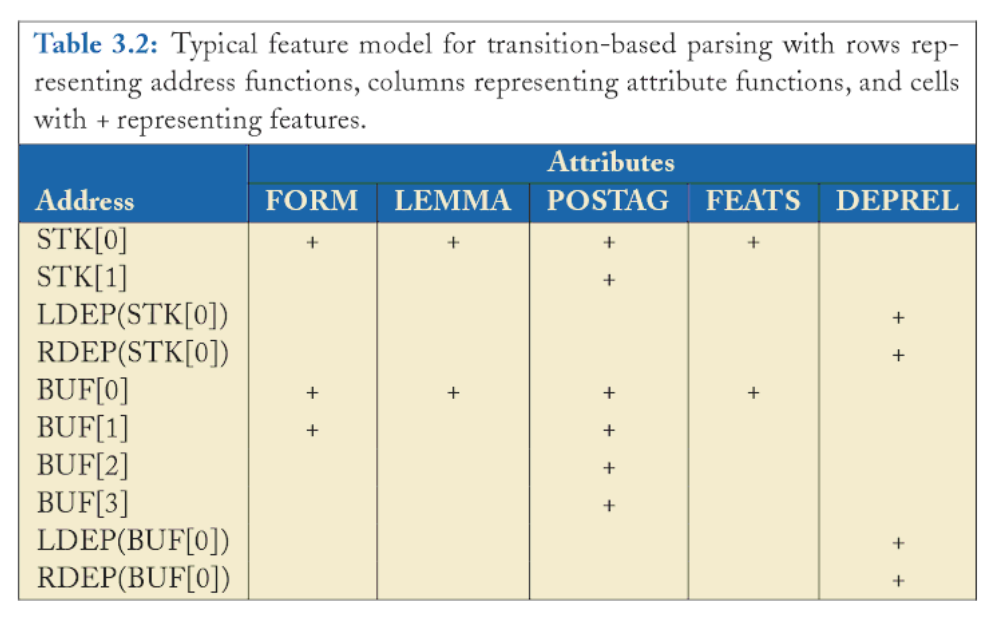

In [18]:
from IPython.display import Image
Image(filename='features.png') 

In [19]:
def create_features(stack, buf):
    fetaures = dict()
    if len(stack) > 0:
        fetaures['s-0-form'] = stack[-1]['form']
        fetaures['s-0-lemma'] = stack[-1]['lemma']
        fetaures['s-0-postag'] = stack[-1]['upostag']
#         fetaures['s-0-feats'] = stack[0]['feats']

        
        if len(stack) > 1:
            fetaures['s-1-postag'] = stack[-2]['upostag']
            
    if len(buf) > 0:
        fetaures['b-0-form'] = buf[0]['form']
        fetaures['b-0-lemma'] = buf[0]['lemma']
        fetaures['b-0-postag'] = buf[0]['upostag']
#         fetaures['b-0-feats'] = buf[0]['feats']
    
    if len(buf) > 1:
        fetaures['b-1-form'] = buf[1]['form']
        fetaures['b-1-postag'] = buf[1]['upostag']
    
    if len(buf) > 2:
        fetaures['b-2-postag'] = buf[2]['upostag']
    
    if len(buf) > 3:
        fetaures['b-3-postag'] = buf[3]['upostag']


    return fetaures

### 4. Дістати тренувальні та тестувальні дані

* Написати функцію, яка дістає з дерева набір переходів та набір ознак для цих переходів.

In [23]:
def get_data(tree, feature_creator):
    features, labels = [], []
    stack, queue, relations = [ROOT], tree[:], []

    while queue or stack:
        action = oracle(stack if len(stack) > 0 else None,
                        queue[0] if len(queue) > 0 else None,
                        relations)
        features.append(feature_creator(stack, queue))
        labels.append(action.value)
        if action == Actions.SHIFT:
            stack.append(queue.pop(0))
        elif action == Actions.REDUCE:
            stack.pop()
        elif action == Actions.LEFT:
            relations.append((stack[-1]["id"], queue[0]["id"]))
            stack.pop()
        elif action == Actions.RIGHT:
            relations.append((queue[0]["id"], stack[-1]["id"]))
            stack.append(queue.pop(0))
        else:
            print("Unknown action.")
    return features, labels


In [24]:
def get_data_for_trees(trees, feature_creator):
    features_list, labels_list = [], []
    for i in range(0, len(train_trees)):
        features, labels = get_data([t for t in train_trees[i] if type(t['id']) == int], feature_creator)
        features_list.append(features)
        labels_list.append(labels)
        
    return features_list, labels_list

In [25]:
features, labels = get_data(train_trees[0], create_features)

In [26]:
features

[{'s-0-form': 'ROOT',
  's-0-lemma': 'ROOT',
  's-0-postag': 'ROOT',
  'b-0-form': 'У',
  'b-0-lemma': 'у',
  'b-0-postag': 'ADP',
  'b-1-form': 'домі',
  'b-1-postag': 'NOUN',
  'b-2-postag': 'ADJ',
  'b-3-postag': 'NOUN'},
 {'s-0-form': 'У',
  's-0-lemma': 'у',
  's-0-postag': 'ADP',
  's-1-postag': 'ROOT',
  'b-0-form': 'домі',
  'b-0-lemma': 'дім',
  'b-0-postag': 'NOUN',
  'b-1-form': 'римського',
  'b-1-postag': 'ADJ',
  'b-2-postag': 'NOUN',
  'b-3-postag': 'PROPN'},
 {'s-0-form': 'ROOT',
  's-0-lemma': 'ROOT',
  's-0-postag': 'ROOT',
  'b-0-form': 'домі',
  'b-0-lemma': 'дім',
  'b-0-postag': 'NOUN',
  'b-1-form': 'римського',
  'b-1-postag': 'ADJ',
  'b-2-postag': 'NOUN',
  'b-3-postag': 'PROPN'},
 {'s-0-form': 'домі',
  's-0-lemma': 'дім',
  's-0-postag': 'NOUN',
  's-1-postag': 'ROOT',
  'b-0-form': 'римського',
  'b-0-lemma': 'римський',
  'b-0-postag': 'ADJ',
  'b-1-form': 'патриція',
  'b-1-postag': 'NOUN',
  'b-2-postag': 'PROPN',
  'b-3-postag': 'VERB'},
 {'s-0-form': '

* Пройтися по всіх деревах у тренувальній вибірці та дістати всі переходи з ознаками.

In [27]:
train_features, train_labels = get_data_for_trees(train_trees, create_features)

In [28]:
train_features_flatten = [item for sublist in train_features for item in sublist]
train_labels_flatten = [item for sublist in train_labels for item in sublist]

* Пройтися по всіх деревах у тестувальній вибірці та дістати всі переходи з ознаками.

In [29]:
dev_features, dev_labels = get_data_for_trees(dev_trees, create_features)

In [30]:
dev_features_flatten = [item for sublist in dev_features for item in sublist]
dev_labels_flatten = [item for sublist in dev_labels for item in sublist]

### 5. Натренувати класифікатор

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [32]:
clf = Pipeline([
    ('vect', DictVectorizer()),
    ('log_reg', LogisticRegression(multi_class='multinomial', random_state=42, solver='lbfgs'))
])

In [33]:
clf.fit(train_features_flatten, train_labels_flatten)

Pipeline(memory=None,
         steps=[('vect',
                 DictVectorizer(dtype=<class 'numpy.float64'>, separator='=',
                                sort=True, sparse=True)),
                ('log_reg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='multinomial', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [34]:
pred_labels = clf.predict(dev_features_flatten)
print(classification_report(
    dev_labels_flatten, pred_labels
))

              precision    recall  f1-score   support

        left       0.91      0.94      0.92     48195
      reduce       0.93      0.90      0.91     49702
       right       0.89      0.89      0.89     42685
       shift       0.92      0.93      0.92     49716

    accuracy                           0.91    190298
   macro avg       0.91      0.91      0.91    190298
weighted avg       0.91      0.91      0.91    190298



### 6. Вирахувати unlabeled attachment score (UAS)

* Скільки залежностей у побудованому дереві збіглося з еталонним деревом? <br>
* Порахувати на тестувальній вибірці.


UAS - the percentage of words in an input that are assign the correct head.

In [35]:
def dep_parse(tree, oracle, feature_creator = create_features):
    stack, queue, relations = [ROOT], tree[:], []
    while queue or stack:   
        if stack and not queue:
            stack.pop()
        
        else:
            features = feature_creator(stack, queue)
#             print(features)
            action = oracle.predict([features])[0]
#             print(action)
#             actions.append(action)
            if action == Actions.SHIFT:
                stack.append(queue.pop(0))
            elif action == Actions.REDUCE:
                stack.pop()
            elif action == Actions.LEFT:
                relations.append((stack[-1]["id"], queue[0]["id"]))
                stack.pop()
            elif action == Actions.RIGHT:
                relations.append((queue[0]["id"], stack[-1]["id"]))
                stack.append(queue.pop(0))
            else:
                print("Unknown action.")
    return sorted(relations)

In [36]:
def calc_unlabeled_attachment_score(trees, oracle, feature_creator=create_features):
    total, tp = 0, 0
    for tree in trees:
        try:
            tree = [t for t in tree if type(t['id']) == int]
            etalon = [(node['id'], node['head']) for node in tree]
            pred = dep_parse(tree, oracle, feature_creator)
            total += len(tree)
            tp += len(set(etalon).intersection(set(pred)))
        except:
            pass
            
    
    uas = round(tp / total, 2)
    
    return total, tp, uas

In [37]:
total, tp, uas = calc_unlabeled_attachment_score(dev_trees, clf)

In [38]:
def print_uas_result(total, tp, uas):
    print("Total", total)
    print("Correct", tp)
    print("UAS", uas)

In [39]:
print_uas_result(total, tp, uas)

Total 12574
Correct 8682
UAS 0.69


Зафіксуємо дані як метрику базового рішення. 

## I. Покращення парсера залежностей

#### Додавання нових ознак

Під час додавання нових ознак, аналізуємо секцію features з https://web.stanford.edu/~jurafsky/slp3/15.pdf

##### Використовуємо *feats* атрибуту

In [40]:
def create_feets_feature(features, feats, prefix):
    if feats is not None and feats != 'None':
        if type(feats) is str:
            m = re.match(r'^OrderedDict\((.+)\)$', feats)
            feats = OrderedDict(ast.literal_eval(m.group(1)))
            
        for key in feats:
            f_key = f"{prefix}-{key}"
            features[f_key] = feats[key]

In [41]:
def create_features_use_feats(stack, buf):
    fetaures = create_features(stack, buf)
    if len(stack) > 0:
        create_feets_feature(fetaures, stack[-1]['feats'], 's-0-feats')
                    
    if len(buf) > 0:
        create_feets_feature(fetaures, buf[0]['feats'], 'b-0-feats')

    return fetaures

##### Використовуємо *feats* атрибуту

In [42]:
train_features, train_labels = get_data_for_trees(train_trees, create_features_use_feats)
train_features_flatten = [item for sublist in train_features for item in sublist]
train_labels_flatten = [item for sublist in train_labels for item in sublist]

In [43]:
clf.fit(train_features_flatten, train_labels_flatten)

Pipeline(memory=None,
         steps=[('vect',
                 DictVectorizer(dtype=<class 'numpy.float64'>, separator='=',
                                sort=True, sparse=True)),
                ('log_reg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='multinomial', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [44]:
dev_features, dev_labels = get_data_for_trees(dev_trees, create_features_use_feats)
dev_features_flatten = [item for sublist in dev_features for item in sublist]
dev_labels_flatten = [item for sublist in dev_labels for item in sublist]

In [45]:
pred_labels = clf.predict(dev_features_flatten)
print(classification_report(
    dev_labels_flatten, pred_labels
))

              precision    recall  f1-score   support

        left       0.90      0.93      0.91     48195
      reduce       0.92      0.88      0.90     49702
       right       0.88      0.88      0.88     42685
       shift       0.91      0.92      0.91     49716

    accuracy                           0.90    190298
   macro avg       0.90      0.90      0.90    190298
weighted avg       0.90      0.90      0.90    190298



In [46]:
total, tp, uas = calc_unlabeled_attachment_score(dev_trees, clf, create_features_use_feats)
print_uas_result(total, tp, uas)

Total 12574
Correct 8971
UAS 0.71


Як бачимо, uas трішки покращився але не значно (0.71 > 0.69)

Так як в главі **Dependency Parser** книги **Speech and Language Processing** в секції *Features* описано наступне: <br>
*Given that the left and right arc transitions operate on the top two elements of
the stack, features that combine properties from these positions are even more useful.
For example, a feature like s1.t ◦ s2.t concatenates the part of speech tag of the word
at the top of the stack with the tag of the word beneath it.*
Тож спробуємо зкомбінувати пари властивості в одну фічу

In [47]:
def create_features_with_combined_props(stack, buf):
    features = create_features_use_feats(stack, buf)
    for i in range(1, len(stack)):
        features[f"s0-word_s{i}-word"] = stack[-1]["form"] + stack[-i-1]["form"]
        features[f"s0-tag_s{i}-tag"] = stack[-1]["upostag"] + stack[-i-1]["upostag"]
        features[f"s0-wordtag_s{i}-tag"] = stack[-1]["form"] + stack[-1]["upostag"] + stack[-i-1]["upostag"]
        features[f"s0-tag_s{i}-wordtag"] = stack[-1]["upostag"] + stack[-i-1]["form"] + stack[-i-1]["upostag"]
#         features[f"s0s{i}-distance"] = stack[-1]["id"] - stack[-2]["id"]
        
#     if stack and buf:
#         features["s0-tag_q0-word"] = stack[-1]["upostag"] + buf[0]["form"]
#         features["s0-wordtag_q0-tag"] = stack[-1]["form"] + stack[-1]["upostag"] + buf[0]["upostag"]
#         features["s0q0-distance"] = buf[0]["id"] - stack[-1]["id"]

        
    return features


In [48]:
train_features, train_labels = get_data_for_trees(train_trees, create_features_with_combined_props)
train_features_flatten = [item for sublist in train_features for item in sublist]
train_labels_flatten = [item for sublist in train_labels for item in sublist]

In [49]:
clf.fit(train_features_flatten, train_labels_flatten)

Pipeline(memory=None,
         steps=[('vect',
                 DictVectorizer(dtype=<class 'numpy.float64'>, separator='=',
                                sort=True, sparse=True)),
                ('log_reg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='multinomial', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [50]:
dev_features, dev_labels = get_data_for_trees(dev_trees, create_features_with_combined_props)
dev_features_flatten = [item for sublist in dev_features for item in sublist]
dev_labels_flatten = [item for sublist in dev_labels for item in sublist]

In [51]:
pred_labels = clf.predict(dev_features_flatten)
print(classification_report(
    dev_labels_flatten, pred_labels
))

              precision    recall  f1-score   support

        left       0.97      0.98      0.97     48195
      reduce       0.98      0.97      0.97     49702
       right       0.94      0.94      0.94     42685
       shift       0.96      0.96      0.96     49716

    accuracy                           0.96    190298
   macro avg       0.96      0.96      0.96    190298
weighted avg       0.96      0.96      0.96    190298



Такі високі показники F1-score можуть говорити про overfitting на на подібних даних, або ж ми використали якісь фічі які спричиняють data leakage.

In [52]:
total, tp, uas = calc_unlabeled_attachment_score(dev_trees, clf, create_features_with_combined_props)
print_uas_result(total, tp, uas)

Total 12574
Correct 9183
UAS 0.73


Як бачимо експеримент з комбінацією фіч  покращив результат. 

#### Пробуємо інший класифікатор

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [54]:
svm_classifier = Pipeline([
    ('vect', DictVectorizer()),
    ('mlp', LinearSVC(tol=1e-5, random_state=42))
])

In [55]:
svm_classifier.fit(train_features_flatten, train_labels_flatten)

Pipeline(memory=None,
         steps=[('vect',
                 DictVectorizer(dtype=<class 'numpy.float64'>, separator='=',
                                sort=True, sparse=True)),
                ('mlp',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=42,
                           tol=1e-05, verbose=0))],
         verbose=False)

In [56]:
pred_labels = svm_classifier.predict(dev_features_flatten)
print(classification_report(
    dev_labels_flatten, pred_labels
))

              precision    recall  f1-score   support

        left       1.00      1.00      1.00     48195
      reduce       1.00      1.00      1.00     49702
       right       0.99      0.99      0.99     42685
       shift       0.99      0.99      0.99     49716

    accuracy                           1.00    190298
   macro avg       1.00      1.00      1.00    190298
weighted avg       1.00      1.00      1.00    190298



In [57]:
total, tp, uas = calc_unlabeled_attachment_score(dev_trees, svm_classifier, create_features_with_combined_props)
print_uas_result(total, tp, uas)

Total 12574
Correct 8775
UAS 0.7


Як бачимо з таблиці *classification report* видно що svm   дає нереальний f1-score, що є більш підозрою до overfiting, чи data leakage, проте  UAS гірше ніж для Логістичної регресії. 

Отже так як логістична регресія дає найкращий uas результат на дев корпусі, поміряємо uas для тестових даних. 

In [58]:
test_features, test_labels = get_data_for_trees(test_trees, create_features_with_combined_props)
test_features_flatten = [item for sublist in test_features for item in sublist]
test_labels_flatten = [item for sublist in test_labels for item in sublist]

In [59]:
pred_test_labels = clf.predict(test_features_flatten)
print(classification_report(
    test_labels_flatten, pred_test_labels
))

              precision    recall  f1-score   support

        left       0.97      0.98      0.97     48195
      reduce       0.98      0.97      0.97     49702
       right       0.94      0.94      0.94     42685
       shift       0.96      0.96      0.96     49716

    accuracy                           0.96    190298
   macro avg       0.96      0.96      0.96    190298
weighted avg       0.96      0.96      0.96    190298



In [60]:
total, tp, uas = calc_unlabeled_attachment_score(test_trees, clf, create_features_with_combined_props)
print_uas_result(total, tp, uas)

Total 17116
Correct 12459
UAS 0.73


Отже результат UAS на dev корпусі тестових 0.96, на test 0.73

## II. Використання парсера на нових даних

In [353]:
import stanfordnlp

In [354]:
nlp_uk = stanfordnlp.Pipeline(lang="uk")

Use device: gpu
---
Loading: tokenize
With settings: 
{'model_path': '/home/dbabenko/stanfordnlp_resources/uk_iu_models/uk_iu_tokenizer.pt', 'lang': 'uk', 'shorthand': 'uk_iu', 'mode': 'predict'}
---
Loading: pos
With settings: 
{'model_path': '/home/dbabenko/stanfordnlp_resources/uk_iu_models/uk_iu_tagger.pt', 'pretrain_path': '/home/dbabenko/stanfordnlp_resources/uk_iu_models/uk_iu.pretrain.pt', 'lang': 'uk', 'shorthand': 'uk_iu', 'mode': 'predict'}
---
Loading: lemma
With settings: 
{'model_path': '/home/dbabenko/stanfordnlp_resources/uk_iu_models/uk_iu_lemmatizer.pt', 'lang': 'uk', 'shorthand': 'uk_iu', 'mode': 'predict'}
Building an attentional Seq2Seq model...
Using a Bi-LSTM encoder
Using soft attention for LSTM.
Finetune all embeddings.
[Running seq2seq lemmatizer with edit classifier]
---
Loading: depparse
With settings: 
{'model_path': '/home/dbabenko/stanfordnlp_resources/uk_iu_models/uk_iu_parser.pt', 'pretrain_path': '/home/dbabenko/stanfordnlp_resources/uk_iu_models/uk_iu

In [355]:
def convert_feats_to_dict(feats):
    result = OrderedDict()
    if feats == "_":
        return None
    
    items = feats.split('|')
    for item in items:
        splited_item = item.split('=')
        key = splited_item[0]
        val = splited_item[1]
        result[key] = val
    
    return result

In [424]:
def create_suitabe_trees(text, nlp):
    result = []
    doc = nlp(text)
    for sent in doc.sentences:
        sent_result = []
        for token in sent.words:
            sent_d = OrderedDict()
            sent_d['id'] = int(token.index)
            sent_d['form'] = token.text
            sent_d['lemma'] = token.lemma
            sent_d['upostag'] = token.upos
            sent_d['xpostag'] = token.xpos
            sent_d['feats'] = convert_feats_to_dict(token.feats)
            sent_d['deprel'] = token.dependency_relation
            sent_d['head'] = int(token.governor)
            
            sent_result.append(sent_d)
    
        result.append(sent_result)
    
    return result

In [425]:
def print_parse_sentence(sentence, nlp, clf, feature_extractor):
    tree = create_suitabe_trees(sentence, nlp)[0]    
    relations = dep_parse(tree, clf, feature_extractor)
    for i in range(0, len(relations)):
        child = tree[relations[i][0] - 1]["form"]
        parent_id = relations[i][1]
        parent = tree[parent_id - 1]['form'] if parent_id > 0 else 'root'
        print(f"{child} <-- {parent}")

#### Застосуємо парсер на кількох українських реченнях 

In [426]:
sent1 = "Якщо ми будемо запускати роботу великих торгових центрів, то нам потрібно буде запускати як мінімум наземний транспорт. "

In [427]:
tree = create_suitabe_trees(sent1, nlp_uk)[0]    

In [428]:
print_parse_sentence(sent1, nlp_uk, clf, create_features_with_combined_props)

Якщо <-- запускати
ми <-- запускати
будемо <-- запускати
роботу <-- запускати
великих <-- центрів
торгових <-- центрів
центрів <-- роботу
, <-- запускати
то <-- потрібно
нам <-- потрібно
потрібно <-- запускати
буде <-- запускати
запускати <-- запускати
як <-- мінімум
мінімум <-- запускати
наземний <-- транспорт
транспорт <-- запускати
. <-- запускати


З результату вище ми бачимо що парсер пропустив слово *запускати*, може бути повязано з тим що для даного токену модель передбачила SHIFT чи REDUCE.

In [429]:
sent2 = "Хоча Ломбок населений переважно мусульманами, але на острові вільно продаються алкогольні напої."

In [431]:
print_parse_sentence(sent2, nlp_uk, clf, create_features_with_combined_props)

Хоча <-- Ломбок
населений <-- Ломбок
переважно <-- населений
мусульманами <-- переважно
на <-- острові
вільно <-- продаються
продаються <-- острові
алкогольні <-- напої
напої <-- продаються
. <-- продаються


З результату вище ми бачимо що парсер пропустив слово *Ломбок* та *острові*, може бути повязано з тим що для даних токенів модель передбачила SHIFT чи REDUCE.

In [434]:
sent3 = "Я люблю пінгвінів."

In [435]:
print_parse_sentence(sent3, nlp_uk, clf, create_features_with_combined_props)

Я <-- люблю
люблю <-- root
пінгвінів <-- люблю
. <-- люблю


Тут бачимо все гаразд. 

In [437]:
sent4 = "Коли буде фінал Ліги Чемпіонів в цьому році?"

In [438]:
print_parse_sentence(sent4, nlp_uk, clf, create_features_with_combined_props)

Коли <-- буде
буде <-- root
фінал <-- буде
Ліги <-- фінал
Чемпіонів <-- Ліги
в <-- році
цьому <-- році
році <-- Чемпіонів
? <-- буде


І в цьому реченні все вірно. 